# ResNet-50 with CutMix Augmentation

Simulate a massive dataset by generating infinite real-time variations, forcing the model to prioritize local textures over global shapes.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import json
import os

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce GTX 960M


**CutMix Augmentation Implementation**

In [3]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    
    # Calculate the size of the box based on lambda
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Choose a random center point
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # Calculate corner coordinates
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_cutmix(data, target, beta=1.0):

    # 1. Generate a random lambda from Beta distribution
    lam = np.random.beta(beta, beta)
    
    # 2. Shuffle the batch to get "Partner" images
    rand_index = torch.randperm(data.size(0)).to(device)
    target_a = target
    target_b = target[rand_index]
    
    # 3. Get the bounding box
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    # 4. Paste the patch
    mixed_data = data.clone()
    mixed_data[:, :, bbx1:bbx2, bby1:bby2] = data[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # 5. Adjust lambda to match the EXACT pixel ratio (more precise)
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(2) * data.size(3)))
    
    return mixed_data, target_a, target_b, lam

**Load Dataset**

In [4]:
# ImageNet normalization values
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transform WITH augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transform (same as baseline)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transforms defined!")
print("✓ Using CutMix augmentation for advanced data variation")

Transforms defined!
✓ Using CutMix augmentation for advanced data variation


In [5]:
data_path = '../dataset-resized'

# Load full dataset first (without transform)
full_dataset_no_transform = datasets.ImageFolder(root=data_path)

print(f"Total images: {len(full_dataset_no_transform)}")
print(f"Classes: {full_dataset_no_transform.classes}")
print(f"Class to index: {full_dataset_no_transform.class_to_idx}")

Total images: 2527
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class to index: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [6]:
# Split: 70% Train, 15% Validation, 15% Test
total_size = len(full_dataset_no_transform)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Use same seed as baseline for fair comparison
torch.manual_seed(42)
indices = torch.randperm(total_size).tolist()

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

print(f"Train size: {len(train_indices)}")
print(f"Validation size: {len(val_indices)}")
print(f"Test size: {len(test_indices)}")

Train size: 1768
Validation size: 379
Test size: 380


In [ ]:
# Create datasets with appropriate transforms
# Training set: WITH augmentation
train_dataset_full = datasets.ImageFolder(root=data_path, transform=train_transform)
train_dataset = Subset(train_dataset_full, train_indices)

# Validation and Test sets: WITHOUT augmentation
val_test_dataset_full = datasets.ImageFolder(root=data_path, transform=val_test_transform)
val_dataset = Subset(val_test_dataset_full, val_indices)
test_dataset = Subset(val_test_dataset_full, test_indices)

# Create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 4  # Parallel CPU workers for data loading & augmentation

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Using {NUM_WORKERS} CPU workers for parallel data loading")

Train batches: 56
Validation batches: 12
Test batches: 12
Using 4 CPU workers for parallel data loading


**Model Setup**

In [8]:
def create_resnet50(num_classes=6, pretrained=True):
    if pretrained:
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        model = models.resnet50(weights=weights)
    else:
        model = models.resnet50(weights=None)
    
    # Replace final FC layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )
    
    return model


model = create_resnet50(num_classes=6, pretrained=True)
model = model.to(device)

print(f"Model loaded on {device}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model loaded on cuda

Total parameters: 23,520,326
Trainable parameters: 23,520,326


**Training Setup**

In [9]:
# Hyperparameters (same as baseline for fair comparison)
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-4

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

print("Training configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Batch size: {BATCH_SIZE}")

Training configuration:
  Learning rate: 0.001
  Epochs: 30
  Weight decay: 0.0001
  Batch size: 32


**Training and Validation Functions**

In [10]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, cutmix_prob=0.5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Apply CutMix with probability
        r = np.random.rand(1)
        if r < cutmix_prob:
            images, targets_a, targets_b, lam = apply_cutmix(images, labels, beta=1.0)
            outputs = model(images)
            loss = criterion(outputs, targets_a) * lam + criterion(outputs, targets_b) * (1. - lam)
            
            # For accuracy, consider dominant label
            _, predicted = torch.max(outputs.data, 1)
            is_correct = (lam > 0.5) * (predicted == targets_a) + (lam <= 0.5) * (predicted == targets_b)
            correct += torch.sum(is_correct).item()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

**Training Loop**

In [11]:
# History for plotting
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0.0
best_model_path = '../best model/best_resnet50_cutmix.pth'
history_path = '../results/cutmix_history.json'  # Save history to file
patience_counter = 0
EARLY_STOP_PATIENCE = 5
CUTMIX_PROB = 0.5

print("="*60)
print("TRAINING RESNET-50 WITH CUTMIX AUGMENTATION")
print("="*60)
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, cutmix_prob=CUTMIX_PROB)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, best_model_path)
        print(f"  → New best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

total_time = time.time() - start_time
print("="*60)
print(f"Training completed in {total_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# Save training history to file
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print(f"Training history saved to {history_path}")

TRAINING RESNET-50 WITH CUTMIX AUGMENTATION
Epoch [ 1/30] | Train Loss: 1.3484 | Train Acc: 50.79% | Val Loss: 1.1053 | Val Acc: 58.05% | Time: 265.9s
  → New best model saved! (Val Acc: 58.05%)
Epoch [ 2/30] | Train Loss: 1.1658 | Train Acc: 59.67% | Val Loss: 0.9298 | Val Acc: 68.34% | Time: 85.0s
  → New best model saved! (Val Acc: 68.34%)
Epoch [ 3/30] | Train Loss: 1.0901 | Train Acc: 63.57% | Val Loss: 1.1790 | Val Acc: 55.41% | Time: 87.4s
Epoch [ 4/30] | Train Loss: 1.0880 | Train Acc: 65.21% | Val Loss: 0.7358 | Val Acc: 74.14% | Time: 86.0s
  → New best model saved! (Val Acc: 74.14%)
Epoch [ 5/30] | Train Loss: 1.0161 | Train Acc: 67.02% | Val Loss: 0.7000 | Val Acc: 77.04% | Time: 85.6s
  → New best model saved! (Val Acc: 77.04%)
Epoch [ 6/30] | Train Loss: 0.9827 | Train Acc: 68.83% | Val Loss: 0.8710 | Val Acc: 64.64% | Time: 85.8s
Epoch [ 7/30] | Train Loss: 1.0437 | Train Acc: 66.23% | Val Loss: 0.6595 | Val Acc: 77.04% | Time: 86.3s
Epoch [ 8/30] | Train Loss: 1.0344 | 

**Plot Training History**

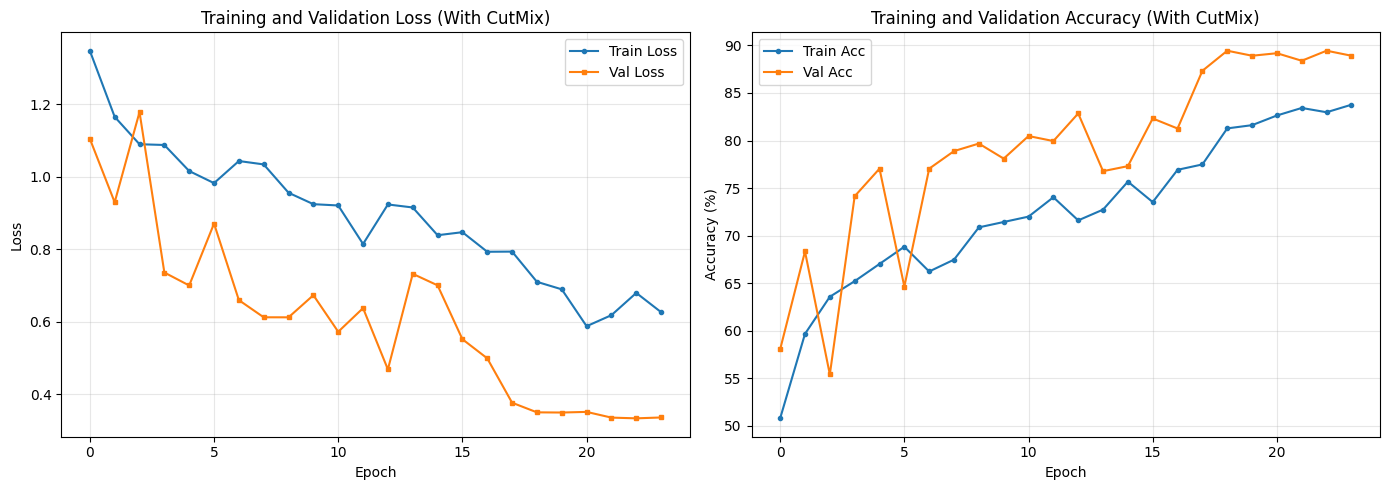

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss (With CutMix)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o', markersize=3)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy (With CutMix)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../plots/training_history_cutmix.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {best_val_acc:.2f}%")

Loaded best model from epoch 19
Validation accuracy: 89.45%


In [14]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT (With CutMix)")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    return all_labels, all_preds

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
all_labels, all_preds = evaluate_model(model, test_loader, device, class_names)


CLASSIFICATION REPORT (With CutMix)
              precision    recall  f1-score   support

   cardboard     1.0000    0.9322    0.9649        59
       glass     0.8941    0.9744    0.9325        78
       metal     0.9219    0.9672    0.9440        61
       paper     0.9149    0.9348    0.9247        92
     plastic     0.9649    0.8333    0.8943        66
       trash     0.8000    0.8333    0.8163        24

    accuracy                         0.9237       380
   macro avg     0.9160    0.9125    0.9128       380
weighted avg     0.9264    0.9237    0.9235       380



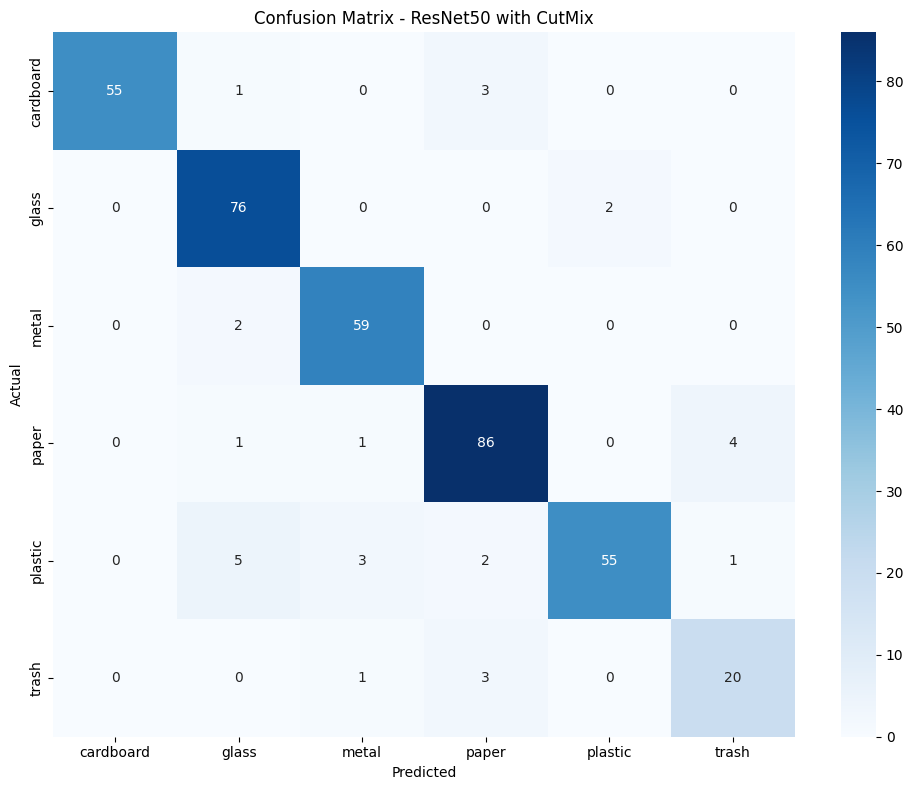

In [15]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ResNet50 with CutMix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../plots/confusion_matrix_cutmix.png', dpi=150, bbox_inches='tight')
plt.show()

**Save Results**

In [16]:
# Calculate final test accuracy
test_accuracy = 100 * sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)

epochs_trained = len(history['train_loss']) if isinstance(history, dict) and 'train_loss' in history else None

# Save results
results = {
    'model': 'ResNet50',
    'experiment': 'With CutMix Augmentation',
    'num_epochs_trained': epochs_trained,
    'best_val_accuracy': best_val_acc,
    'test_accuracy': test_accuracy,
    'augmentations': [
        'RandomCrop(224)',
        'RandomHorizontalFlip(p=0.5)',
        'RandomRotation(15)',
        'ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)',
        'Normalize(ImageNet)',
        'CutMix (p=0.5)'
    ]
}

with open('../results/cutmix_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to '../results/cutmix_results.json'")
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")


Results saved to '../results/cutmix_results.json'

Final Test Accuracy: 92.37%


**Compare with last two model**

COMPARISON: BASELINE vs AUGMENTED vs CUTMIX

Metric                           Baseline       Augmented          CutMix
----------------------------------------------------------------------
Best Val Accuracy                  90.77%          91.03%          89.45%
Test Accuracy                      90.79%          92.37%          92.37%


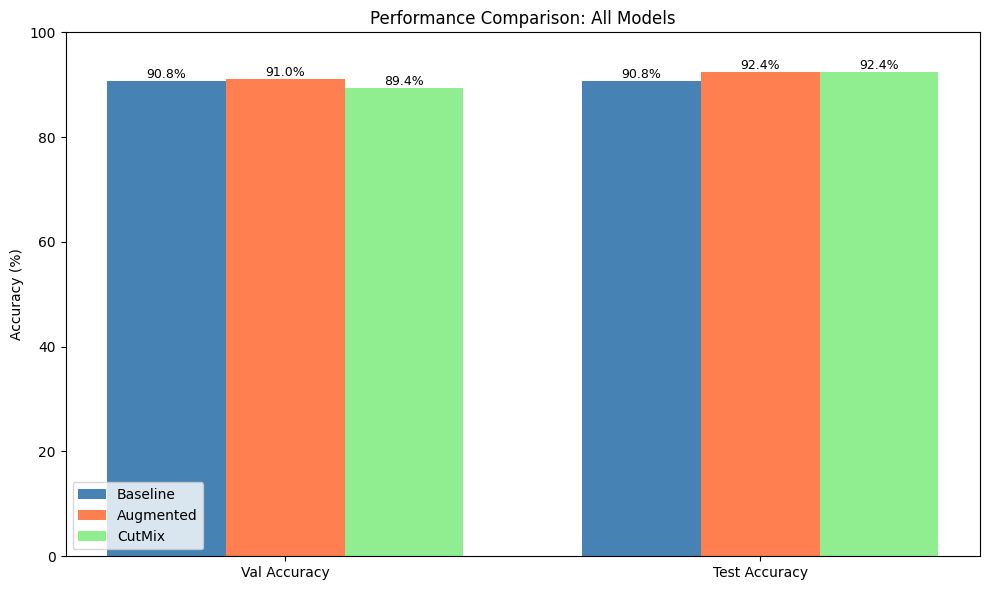

In [17]:
# Load baseline and augmented results for comparison
try:
    with open('../results/baseline_results.json', 'r') as f:
        baseline_results = json.load(f)
    with open('../results/augmented_results.json', 'r') as f:
        augmented_results = json.load(f)
    
    print("="*70)
    print("COMPARISON: BASELINE vs AUGMENTED vs CUTMIX")
    print("="*70)
    print(f"\n{'Metric':<25} {'Baseline':>15} {'Augmented':>15} {'CutMix':>15}")
    print("-"*70)
    
    baseline_val = baseline_results.get('best_val_accuracy', 0)
    baseline_test = baseline_results.get('test_accuracy', 0)
    augmented_val = augmented_results.get('best_val_accuracy', 0)
    augmented_test = augmented_results.get('test_accuracy', 0)
    
    print(f"{'Best Val Accuracy':<25} {baseline_val:>14.2f}% {augmented_val:>14.2f}% {best_val_acc:>14.2f}%")
    print(f"{'Test Accuracy':<25} {baseline_test:>14.2f}% {augmented_test:>14.2f}% {test_accuracy:>14.2f}%")
    
    # Bar chart comparison
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    metrics = ['Val Accuracy', 'Test Accuracy']
    baseline_scores = [baseline_val, baseline_test]
    augmented_scores = [augmented_val, augmented_test]
    cutmix_scores = [best_val_acc, test_accuracy]
    
    x = np.arange(len(metrics))
    width = 0.25
    
    bars1 = ax.bar(x - width, baseline_scores, width, label='Baseline', color='steelblue')
    bars2 = ax.bar(x, augmented_scores, width, label='Augmented', color='coral')
    bars3 = ax.bar(x + width, cutmix_scores, width, label='CutMix', color='lightgreen')
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Performance Comparison: All Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim([0, 100])
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../plots/all_models_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except FileNotFoundError:
    print("Baseline or augmented results file not found. Run the previous notebooks first to enable comparison.")